<h1> Capstone Project for IBM's Data Science course on Coursera

<h2>Introduction

With COVID-19 throwing the economic world into a frenzy many small businesses, and large corporate ones for that matter, have either filed for bankruptcy or closed their doors for good. Unfortunate as this is, up and coming entrepreneurs will face an unprecedented market of corporate real estate for new businesses. Restaurants, Bars/Pubs, Cafes, etc will have an opportunity to open in prime areas for foot traffic and income when the world returns to normalcy or creates a new normalcy after the COVID-19 threat has subsided. Analysis on neighborhoods and current establishments to find an ideal storefront will become ever important in the coming months and  years. This data will be invaluable to new start-ups and can assist them in getting the right patronage and make sure that their business income will be consistent. It will take the guess work out of where to open a business. 

<h2>Business Problem

As an entrepreneur my client has expressed interest in the New York City(NYC) area for his new craft beer pub and lounge, but he wants to pick the right neighborhood for this establishment. With that problem we can assess the things required for his business venture, he will need a middle to upper class neighborhood or borough and an area where there are few other establishments like his but not completely devoid of other establishments. He would like a list of potential neighborhoods for his new start up that fit his criteria so he can start looking for open corporate real estate.

<h2>Data and Methodology

I was able to procure the median household income for each borough and neighborhood in NYC from https://www.renthop.com/study/assets/new-york-city-cost-of-living-2017/nyc-2br-median-rent-and-income-table.html. I will then gather the longitude and latitude of each neighborhood. From there I will run a KMeans test to group like neighborhoods and look for those that fit the household income requirements set by the client (60K+). A new dataset will be created to only include the neighborhoods that fit the middle to upper class household incomes. Then the Foursquare API will be utilized to find the current percentages of venues in the neighborhoods that seem the most promising and from there analyze which neighborhoods would be ideal for my client. The API will provide the information regarding the top business types in each neighborhood which will allow me to figure out where a craft beer pub and lounge would be best suited to get the right consistent patronage. For instance, the Upper West Side of Manhattan has a median income of ~92K making it an ideal neighborhood based on that variable, but after some analysis the top two establishments in the neighborhood are wine bars and bars making the share of the bar market very small for my client which would disqualify it from being considered.

<h2> Part 1: Gathering Data

In [1]:
!conda install -c conda-forge geopy --yes
import requests
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from pandas.io.json import json_normalize
import json

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

<h4>Import NYC data

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

The data I am most interested in comes from the Features aspect of the file so I created a dataframe from those attributes

In [3]:
neighborhoods_data = newyork_data['features']

In [4]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

In [5]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
...,...,...,...,...
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631


<h4> Import median household income for NYC csv file

In [7]:
NY_df = pd.read_csv('Median_Household_Income_NYC.csv')

<h4> Merge the two dataframes to have latitude, longitude, neighborhood, borough, and median household income

In [8]:
#merge the three datasets based on shared Nieghborhood column
merge_nyc = pd.merge(left=neighborhoods, right=NY_df, left_on='Neighborhood', right_on='Neighborhood')
#Drop extra
merge_nyc = merge_nyc.drop(columns=['Borough_y'])

merge_nyc = merge_nyc.rename(columns={'Borough_x': 'Borough', 'Median Household Income': 'MHI'})

merge_nyc

,Borough,Neighborhood,Latitude,Longitude,MHI,Borough Median Household Income
0,Bronx,Fieldston,40.895437,-73.905643,78895,38085
1,Bronx,Riverdale,40.890834,-73.912585,78895,38085
2,Bronx,Kingsbridge,40.881687,-73.902818,67534,38085
3,Manhattan,Marble Hill,40.876551,-73.910660,39003,82459
4,Bronx,Norwood,40.877224,-73.879391,35319,38085
...,...,...,...,...,...,...
156,Brooklyn,Madison,40.609378,-73.948415,55840,56015
157,Brooklyn,Erasmus,40.646926,-73.948177,40681,56015
158,Manhattan,Hudson Yards,40.756658,-74.000111,101369,82459
159,Queens,Hammels,40.587338,-73.805530,39432,64987


<h3> Cursory visualizations of the data

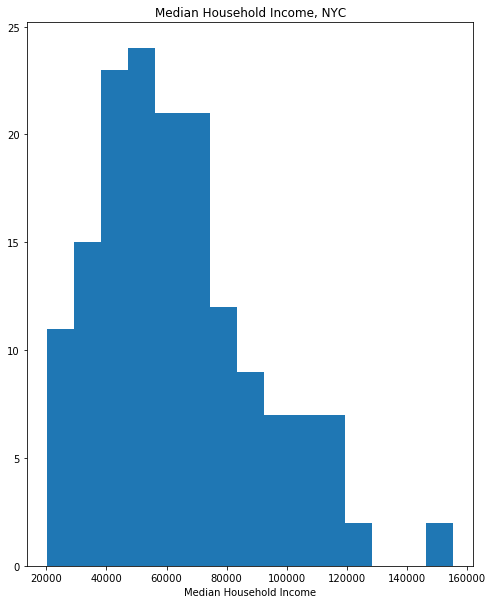

In [9]:
merge_nyc.hist(column='MHI', grid=False, figsize=(8,10), bins=15)
plt.title("Median Household Income, NYC")
plt.xlabel('Median Household Income')

plt.show()

<h4>Now I create a map of NYC and plot the neighborhoods as points

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

<h4> Getting the descriptive stats about the dataset

In [12]:
merge_nyc.describe().drop(columns=['Cluster Labels', 'Latitude', 'Longitude'])

KeyError: "['Cluster Labels'] not found in axis"

<h2> Part 2: Clustering dataset

<h4>The following will run a KMeans test on the data to find like neighborhoods across all of NYC

In [13]:
# set number of clusters
kclusters = 5

nyc_clustering = merge_nyc.drop(columns=['Borough', 'Neighborhood'])

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
merge_nyc.insert(0, 'Cluster Labels', kmeans.labels_)

merge_nyc

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,MHI,Borough Median Household Income
0,2,Bronx,Fieldston,40.895437,-73.905643,78895,38085
1,2,Bronx,Riverdale,40.890834,-73.912585,78895,38085
2,2,Bronx,Kingsbridge,40.881687,-73.902818,67534,38085
3,3,Manhattan,Marble Hill,40.876551,-73.910660,39003,82459
4,1,Bronx,Norwood,40.877224,-73.879391,35319,38085
...,...,...,...,...,...,...,...
156,2,Brooklyn,Madison,40.609378,-73.948415,55840,56015
157,3,Brooklyn,Erasmus,40.646926,-73.948177,40681,56015
158,0,Manhattan,Hudson Yards,40.756658,-74.000111,101369,82459
159,3,Queens,Hammels,40.587338,-73.805530,39432,64987


In [14]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merge_nyc['Latitude'], merge_nyc['Longitude'], merge_nyc['Neighborhood'], merge_nyc['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The map looks different because the two datasets neighborhoods and nyc_df are not exactly the same so the merge drops some neighborhoods.

<h2>Part 3: Analyzing the clusters of neighborhoods

In [15]:
merge_nyc.loc[merge_nyc['Cluster Labels'] == 0, merge_nyc.columns[[0, 1, 2] + list(range(5, merge_nyc.shape[1]))]].sort_values(by=['MHI'], ascending=True)

,Cluster Labels,Borough,Neighborhood,MHI,Borough Median Household Income
82,0,Manhattan,East Village,72665,82459
74,0,Manhattan,Clinton,73591,82459
138,0,Staten Island,Midland Beach,78100,79267
134,0,Staten Island,New Dorp,78100,79267
113,0,Queens,Little Neck,83749,64987
135,0,Staten Island,Great Kills,88868,79267
72,0,Manhattan,Upper West Side,92268,82459
151,0,Manhattan,Stuyvesant Town,95022,82459
78,0,Queens,Murray Hill,97458,82459
76,0,Manhattan,Murray Hill,97458,82459


In [16]:
merge_nyc.loc[merge_nyc['Cluster Labels'] == 1, merge_nyc.columns[[0, 1, 2] + list(range(5, merge_nyc.shape[1]))]].sort_values(by=['MHI'], ascending=True)

,Cluster Labels,Borough,Neighborhood,MHI,Borough Median Household Income
10,1,Bronx,Port Morris,20334,38085
33,1,Brooklyn,Williamsburg,21502,56015
11,1,Bronx,Hunts Point,22572,38085
7,1,Bronx,University Heights,25073,38085
8,1,Bronx,Morris Heights,25073,38085
148,1,Bronx,Mount Hope,26195,38085
147,1,Bronx,Concourse Village,27883,38085
9,1,Bronx,West Farms,29382,38085
6,1,Bronx,Bedford Park,29549,38085
4,1,Bronx,Norwood,35319,38085


In [17]:
merge_nyc.loc[merge_nyc['Cluster Labels'] == 2, merge_nyc.columns[[0, 1, 2] + list(range(5, merge_nyc.shape[1]))]].sort_values(by=['MHI'], ascending=True)

,Cluster Labels,Borough,Neighborhood,MHI,Borough Median Household Income
156,2,Brooklyn,Madison,55840,56015
24,2,Brooklyn,Bay Ridge,57980,56015
109,2,Queens,College Point,58420,64987
144,2,Queens,Jamaica Hills,58564,64987
116,2,Queens,Briarwood,58564,64987
43,2,Brooklyn,Canarsie,60766,56015
114,2,Queens,Kew Gardens Hills,61348,64987
61,2,Brooklyn,South Side,61381,56015
60,2,Brooklyn,North Side,61381,56015
149,2,Queens,Hunters Point,61736,64987


In [18]:
merge_nyc.loc[merge_nyc['Cluster Labels'] == 3, merge_nyc.columns[[0, 1, 2] + list(range(5, merge_nyc.shape[1]))]].sort_values(by=['MHI'], ascending=True)

,Cluster Labels,Borough,Neighborhood,MHI,Borough Median Household Income
160,3,Queens,Queensbridge,28378,64987
125,3,Queens,Ravenswood,28378,64987
99,3,Queens,Long Island City,28378,64987
67,3,Manhattan,Manhattanville,29182,82459
27,3,Brooklyn,Brighton Beach,30872,56015
83,3,Manhattan,Lower East Side,31273,82459
42,3,Brooklyn,East New York,32973,56015
54,3,Brooklyn,Ocean Hill,33125,56015
26,3,Brooklyn,Gravesend,35550,56015
47,3,Brooklyn,Borough Park,35754,56015


In [19]:
merge_nyc.loc[merge_nyc['Cluster Labels'] == 4, merge_nyc.columns[[0, 1, 2] + list(range(5, merge_nyc.shape[1]))]].sort_values(by=['MHI'], ascending=True)

,Cluster Labels,Borough,Neighborhood,MHI,Borough Median Household Income
86,4,Manhattan,West Village,112689,82459
150,4,Manhattan,Turtle Bay,113998,82459
75,4,Manhattan,Midtown,114491,82459
141,4,Manhattan,Midtown South,114491,82459
84,4,Manhattan,Tribeca,118931,82459
85,4,Manhattan,Little Italy,118931,82459
140,4,Manhattan,Civic Center,118931,82459
73,4,Manhattan,Lincoln Square,120337,82459
89,4,Manhattan,Battery Park City,125434,82459
68,4,Manhattan,Upper East Side,155213,82459


<h3> Preliminary analysis

The clusters look to be subsetted by the median household income which was the goal of the KMeans test. Now I am able to see what neighborhoods/clusters fit my client's request of neighborhoods with an annual household income of 60k or more.

<h2> Part 4: Subset data based on client's requirements

In [20]:
aff_nyc = merge_nyc
aff_nyc = aff_nyc[~(aff_nyc['MHI'] <= 60000)]
aff_nyc.sort_values(by=['MHI'], ascending=True)

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,MHI,Borough Median Household Income
43,2,Brooklyn,Canarsie,40.635564,-73.902093,60766,56015
114,2,Queens,Kew Gardens Hills,40.722578,-73.820878,61348,64987
60,2,Brooklyn,North Side,40.714823,-73.958809,61381,56015
61,2,Brooklyn,South Side,40.710861,-73.958001,61381,56015
100,2,Queens,Sunnyside,40.740176,-73.926916,61736,64987
...,...,...,...,...,...,...,...
85,4,Manhattan,Little Italy,40.719324,-73.997305,118931,82459
73,4,Manhattan,Lincoln Square,40.773529,-73.985338,120337,82459
89,4,Manhattan,Battery Park City,40.711932,-74.016869,125434,82459
139,4,Manhattan,Carnegie Hill,40.782683,-73.953256,155213,82459


<h3>Create a map of the new subsetted dataset

In [21]:
# create map of New York using latitude and longitude values
map_aff_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(aff_nyc['Latitude'], aff_nyc['Longitude'], aff_nyc['Borough'], aff_nyc['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_aff_newyork)  
    
map_aff_newyork

<h2> Part 5: Foursquare API venue information

In [22]:
CLIENT_ID = 'XLJGJXBQZONSQSFRBCSXYPKHJMJRSCQDD5ZH5IVXV0ZKYWFK' # your Foursquare ID
CLIENT_SECRET = 'O1DLZTBHTGQZGIXRSLZX2IKKLBCDSFHRPIDXP5GFTXKOCRYX' # your Foursquare Secret
VERSION = '20200518'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XLJGJXBQZONSQSFRBCSXYPKHJMJRSCQDD5ZH5IVXV0ZKYWFK
CLIENT_SECRET:O1DLZTBHTGQZGIXRSLZX2IKKLBCDSFHRPIDXP5GFTXKOCRYX


<h3>Create a function to grab the top 100 venues from Foursquare from all neighborhoods in the dataset

In [23]:
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h3>Run the function to get nearby venues and put them in a dataframe

In [24]:
nyc_aff_venues = getNearbyVenues(names=aff_nyc['Neighborhood'],
                                   latitudes=aff_nyc['Latitude'],
                                   longitudes=aff_nyc['Longitude']
                                  )

Fieldston
Riverdale
Kingsbridge
Throgs Neck
Spuyten Duyvil
North Riverdale
Schuylerville
Edgewater Park
Greenpoint
Windsor Terrace
Prospect Heights
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Canarsie
Flatlands
Marine Park
Clinton Hill
Boerum Hill
Bergen Beach
Georgetown
North Side
South Side
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Murray Hill
Chelsea
Chelsea
East Village
Tribeca
Little Italy
West Village
Gramercy
Battery Park City
Forest Hills
Kew Gardens
Sunnyside
Sunnyside
Glendale
Woodhaven
Ozone Park
Whitestone
Bayside
Auburndale
Little Neck
Kew Gardens Hills
Fresh Meadows
Broad Channel
Breezy Point
Bay Terrace
Bay Terrace
Belle Harbor
Rockaway Park
Port Richmond
New Dorp
Great Kills
Midland Beach
Carnegie Hill
Civic Center
Midtown South
Mill Basin
Utopia
Hunters Point
Turtle Bay
Stuyvesant Town
Vinegar Hill
Dumbo
Middle Village
Hudson Yards


In [25]:
nyc_aff_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Fieldston,40.895437,-73.905643,Fieldston Road Circle,40.894489,-73.905621,Plaza
1,Fieldston,40.895437,-73.905643,Riverside Drive,40.896507,-73.908261,River
2,Fieldston,40.895437,-73.905643,MTA MaBSTOA Bus Bx7 / Bx10 / Bx20 / BxM1 / BxM...,40.893548,-73.908151,Bus Station
3,Fieldston,40.895437,-73.905643,Alba Portable Oxygen Concentrator,40.893022,-73.910400,Medical Supply Store
4,Riverdale,40.890834,-73.912585,Riverdale Ave,40.890425,-73.910248,Plaza


<h3> Check the count of venues per neighborhood

In [26]:
nyc_aff_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Auburndale,19,19,19,19,19,19
Battery Park City,64,64,64,64,64,64
Bay Terrace,49,49,49,49,49,49
Bayside,71,71,71,71,71,71
Belle Harbor,17,17,17,17,17,17
...,...,...,...,...,...,...
West Village,100,100,100,100,100,100
Whitestone,4,4,4,4,4,4
Windsor Terrace,27,27,27,27,27,27


<h3>Create a dataframe with dummy variables base on the type of venues in the dataset from Foursquare

In [27]:
# one hot encoding
aff_nyc_onehot = pd.get_dummies(nyc_aff_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
aff_nyc_onehot['Neighborhood'] = nyc_aff_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [aff_nyc_onehot.columns[-1]] + list(aff_nyc_onehot.columns[:-1])
aff_nyc_onehot = aff_nyc_onehot[fixed_columns]

aff_nyc_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Volleyball Court,Warehouse Store,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Fieldston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fieldston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fieldston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fieldston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Riverdale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3> Create a dataframe of the mean of occurances for each venue type in each neighborhood

In [28]:
aff_nyc_grouped = aff_nyc_onehot.groupby('Neighborhood').mean().reset_index()
aff_nyc_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Volleyball Court,Warehouse Store,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Auburndale,0.000000,0.0,0.052632,0.0,0.000000,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,Battery Park City,0.000000,0.0,0.015625,0.0,0.000000,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.015625,0.0,0.015625,0.000000
2,Bay Terrace,0.020408,0.0,0.040816,0.0,0.000000,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.020408,0.0,0.000000,0.000000,0.0,0.040816,0.000000
3,Bayside,0.000000,0.0,0.042254,0.0,0.000000,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.014085,0.000000,0.0,0.000000,0.014085
4,Belle Harbor,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,West Village,0.000000,0.0,0.040000,0.0,0.000000,0.0,0.00,0.0,0.01,...,0.0,0.0,0.0,0.000000,0.0,0.050000,0.010000,0.0,0.000000,0.000000
72,Whitestone,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
73,Windsor Terrace,0.000000,0.0,0.037037,0.0,0.037037,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.037037,0.0,0.000000,0.000000
74,Woodhaven,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.04,0.0,0.00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


<h3>Define a function to gather the top ten venues for each neighborhood

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = aff_nyc_grouped['Neighborhood']

for ind in np.arange(aff_nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(aff_nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Auburndale,Mobile Phone Shop,Athletics & Sports,Sushi Restaurant,Supermarket,Korean Restaurant,Furniture / Home Store,Gymnastics Gym,Toy / Game Store,Discount Store,Train
1,Battery Park City,Park,Hotel,Memorial Site,Gym,Coffee Shop,Plaza,Shopping Mall,Beer Garden,Gourmet Shop,Food Court
2,Bay Terrace,Clothing Store,Supermarket,Donut Shop,Shoe Store,Mobile Phone Shop,Lingerie Store,Kids Store,Women's Store,Italian Restaurant,American Restaurant
3,Bayside,Bar,Pizza Place,American Restaurant,Indian Restaurant,Sushi Restaurant,Mexican Restaurant,Ice Cream Shop,Pub,Spa,Greek Restaurant
4,Belle Harbor,Beach,Spa,Deli / Bodega,Pub,Pharmacy,Bakery,Bagel Shop,Donut Shop,Mexican Restaurant,Boutique


<h2>Part 6: Cluster data based on venue

In [31]:
# set number of clusters
kclusters = 5

aff_grouped_clustering = aff_nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(aff_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 1, 4, 0], dtype=int32)

In [32]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

aff_merged = aff_nyc


#aff_merged.drop(columns=['Cluster Labels'], inplace=True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
aff_merged = aff_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

aff_merged # check the last columns!

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,MHI,Borough Median Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Bronx,Fieldston,40.895437,-73.905643,78895,38085,River,Plaza,Bus Station,Medical Supply Store,Farmers Market,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Factory
1,2,Bronx,Riverdale,40.890834,-73.912585,78895,38085,Bus Station,Park,Bank,Gym,Baseball Field,Plaza,Playground,Food,Factory,Egyptian Restaurant
2,2,Bronx,Kingsbridge,40.881687,-73.902818,67534,38085,Pizza Place,Bar,Latin American Restaurant,Sandwich Place,Supermarket,Mexican Restaurant,Bakery,Donut Shop,Pharmacy,Fried Chicken Joint
14,2,Bronx,Throgs Neck,40.815109,-73.816350,67549,38085,Bar,Deli / Bodega,Juice Bar,Asian Restaurant,Coffee Shop,Sports Bar,Italian Restaurant,Chinese Restaurant,American Restaurant,Pizza Place
18,2,Bronx,Spuyten Duyvil,40.881395,-73.917190,67534,38085,Park,Scenic Lookout,Pharmacy,Bank,Tennis Court,Thai Restaurant,Tennis Stadium,Filipino Restaurant,Fish & Chips Shop,Food
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0,Manhattan,Stuyvesant Town,40.731000,-73.974052,95022,82459,Playground,Park,Boat or Ferry,Baseball Field,Pet Service,Bar,Gym / Fitness Center,Cocktail Bar,Harbor / Marina,Bistro
152,2,Brooklyn,Vinegar Hill,40.703321,-73.981116,84945,56015,Food Truck,Coffee Shop,Café,Art Gallery,Performing Arts Venue,Bookstore,Factory,Scenic Lookout,Bike Rental / Bike Share,Entertainment Service
153,2,Brooklyn,Dumbo,40.703176,-73.988753,84945,56015,Park,Coffee Shop,Scenic Lookout,Boxing Gym,Pizza Place,Art Gallery,Café,Yoga Studio,Gym,American Restaurant
155,2,Queens,Middle Village,40.716415,-73.881143,69763,64987,Chinese Restaurant,Pizza Place,Dessert Shop,Sports Bar,Sushi Restaurant,Electronics Store,Sandwich Place,Bank,Bakery,Park


<h3> Create a map of new clusters

In [33]:
# create map
map_options = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(aff_merged['Latitude'], aff_merged['Longitude'], aff_merged['Neighborhood'], aff_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_options)
       
map_options

<h2>Part 7: Analyze cluster data

In [44]:
aff_merged.loc[aff_merged['Cluster Labels'] == 0, aff_merged.columns[[0, 2] + list(range(4, aff_merged.shape[1]))]].sort_values(by=['MHI'], ascending=True)

,Cluster Labels,Neighborhood,Longitude,MHI,Borough Median Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
82,0,East Village,-73.982226,72665,82459,Bar,Mexican Restaurant,Coffee Shop,Cocktail Bar,Japanese Restaurant,Speakeasy,Wine Bar,Juice Bar,Pizza Place,Ice Cream Shop
74,0,Clinton,-73.996119,73591,82459,Theater,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Wine Shop,Gym,Hotel,Spa,American Restaurant,Sandwich Place
138,0,Midland Beach,-74.093483,78100,79267,Beach,Restaurant,Pet Store,Baseball Field,Electronics Store,Chinese Restaurant,Bookstore,Liquor Store,Bus Stop,Deli / Bodega
134,0,New Dorp,-74.116479,78100,79267,Italian Restaurant,Indian Restaurant,Pizza Place,Sushi Restaurant,Bakery,Bank,Gas Station,Taco Place,Train Station,Dim Sum Restaurant
113,0,Little Neck,-73.738898,83749,64987,Chinese Restaurant,Deli / Bodega,Korean Restaurant,Italian Restaurant,Spa,Coffee Shop,Pizza Place,Bakery,Bank,Cantonese Restaurant
135,0,Great Kills,-74.149324,88868,79267,Pizza Place,Italian Restaurant,Bar,Grocery Store,Japanese Restaurant,Sandwich Place,Food & Drink Shop,Nightclub,Cafeteria,Dessert Shop
72,0,Upper West Side,-73.977059,92268,82459,Italian Restaurant,Bar,Wine Bar,Dessert Shop,Indian Restaurant,Mexican Restaurant,Pub,Pizza Place,Bakery,Bagel Shop
151,0,Stuyvesant Town,-73.974052,95022,82459,Playground,Park,Boat or Ferry,Baseball Field,Pet Service,Bar,Gym / Fitness Center,Cocktail Bar,Harbor / Marina,Bistro
78,0,Murray Hill,-73.812763,97458,82459,Korean Restaurant,Hotel,Coffee Shop,Sandwich Place,Pizza Place,Bar,Gym / Fitness Center,Japanese Restaurant,Cuban Restaurant,Steakhouse
76,0,Murray Hill,-73.978332,97458,82459,Korean Restaurant,Hotel,Coffee Shop,Sandwich Place,Pizza Place,Bar,Gym / Fitness Center,Japanese Restaurant,Cuban Restaurant,Steakhouse


In [43]:
aff_merged.loc[aff_merged['Cluster Labels'] == 1, aff_merged.columns[[0, 2] + list(range(4, aff_merged.shape[1]))]]

,Cluster Labels,Neighborhood,Longitude,MHI,Borough Median Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [42]:
aff_merged.loc[aff_merged['Cluster Labels'] == 2, aff_merged.columns[[0, 2] + list(range(4, aff_merged.shape[1]))]]

,Cluster Labels,Neighborhood,Longitude,MHI,Borough Median Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Fieldston,-73.905643,78895,38085,River,Plaza,Bus Station,Medical Supply Store,Farmers Market,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Factory
1,2,Riverdale,-73.912585,78895,38085,Bus Station,Park,Bank,Gym,Baseball Field,Plaza,Playground,Food,Factory,Egyptian Restaurant
2,2,Kingsbridge,-73.902818,67534,38085,Pizza Place,Bar,Latin American Restaurant,Sandwich Place,Supermarket,Mexican Restaurant,Bakery,Donut Shop,Pharmacy,Fried Chicken Joint
14,2,Throgs Neck,-73.816350,67549,38085,Bar,Deli / Bodega,Juice Bar,Asian Restaurant,Coffee Shop,Sports Bar,Italian Restaurant,Chinese Restaurant,American Restaurant,Pizza Place
18,2,Spuyten Duyvil,-73.917190,67534,38085,Park,Scenic Lookout,Pharmacy,Bank,Tennis Court,Thai Restaurant,Tennis Stadium,Filipino Restaurant,Fish & Chips Shop,Food
19,2,North Riverdale,-73.904531,78895,38085,Pizza Place,Italian Restaurant,Bank,Ice Cream Shop,Donut Shop,Burger Joint,Bus Station,Mexican Restaurant,Sushi Restaurant,Chinese Restaurant
20,2,Schuylerville,-73.826203,67549,38085,Convenience Store,Pizza Place,American Restaurant,Diner,Mexican Restaurant,Pharmacy,Japanese Restaurant,Fast Food Restaurant,Donut Shop,Bank
21,2,Edgewater Park,-73.813885,67549,38085,Italian Restaurant,Deli / Bodega,Pizza Place,Donut Shop,Coffee Shop,Bar,Pub,Park,Food & Drink Shop,Sports Bar
25,2,Greenpoint,-73.954241,67928,56015,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Yoga Studio,Café,Sushi Restaurant,French Restaurant,Deli / Bodega,Grocery Store
31,2,Windsor Terrace,-73.980073,82297,56015,Park,Grocery Store,Plaza,Diner,Café,Deli / Bodega,Sushi Restaurant,Coffee Shop,Chinese Restaurant,Bar


In [41]:
aff_merged.loc[aff_merged['Cluster Labels'] == 3, aff_merged.columns[[0, 2] + list(range(4, aff_merged.shape[1]))]].sort_values(by=['MHI'], ascending=True)

,Cluster Labels,Neighborhood,Longitude,MHI,Borough Median Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [45]:
aff_merged.loc[aff_merged['Cluster Labels'] == 4, aff_merged.columns[[0, 1, 2] + list(range(4, aff_merged.shape[1]))]]

,Cluster Labels,Borough,Neighborhood,Longitude,MHI,Borough Median Household Income,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,4,Manhattan,Upper East Side,-73.960508,155213,82459,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Bakery,Yoga Studio,Exhibit,Spa,French Restaurant,Juice Bar,Salad Place
73,4,Manhattan,Lincoln Square,-73.985338,120337,82459,Café,Italian Restaurant,Plaza,Theater,Gym / Fitness Center,Performing Arts Venue,Concert Hall,Wine Shop,Indie Movie Theater,American Restaurant
75,4,Manhattan,Midtown,-73.981669,114491,82459,Coffee Shop,Hotel,Theater,Bakery,Pizza Place,Clothing Store,American Restaurant,Cuban Restaurant,Sushi Restaurant,Sandwich Place
84,4,Manhattan,Tribeca,-74.010683,118931,82459,Park,Italian Restaurant,American Restaurant,Coffee Shop,Spa,Wine Bar,Café,French Restaurant,Bakery,Steakhouse
85,4,Manhattan,Little Italy,-73.997305,118931,82459,Bubble Tea Shop,Mediterranean Restaurant,Ice Cream Shop,Italian Restaurant,Pizza Place,Bakery,Spa,Thai Restaurant,Sandwich Place,Chinese Restaurant
86,4,Manhattan,West Village,-74.006180,112689,82459,Italian Restaurant,New American Restaurant,Wine Bar,Bakery,Pizza Place,American Restaurant,Cocktail Bar,Park,Coffee Shop,Jazz Club
89,4,Manhattan,Battery Park City,-74.016869,125434,82459,Park,Hotel,Memorial Site,Gym,Coffee Shop,Plaza,Shopping Mall,Beer Garden,Gourmet Shop,Food Court
139,4,Manhattan,Carnegie Hill,-73.953256,155213,82459,Coffee Shop,Pizza Place,Café,Bookstore,Gym / Fitness Center,Gym,Japanese Restaurant,Yoga Studio,Wine Shop,Cosmetics Shop
140,4,Manhattan,Civic Center,-74.005415,118931,82459,Coffee Shop,Cocktail Bar,Hotel,Spa,French Restaurant,Park,American Restaurant,Café,Gym / Fitness Center,Yoga Studio
141,4,Manhattan,Midtown South,-73.988713,114491,82459,Korean Restaurant,Hotel,Japanese Restaurant,American Restaurant,Dessert Shop,Café,Burger Joint,Coffee Shop,Hotel Bar,Gym / Fitness Center


<h2> Part 8: Discussion and Analysis

The initial k-means test grouped the lower income areas in purple and teal, the middle-class areas in blue, upper middle class in red, and upper class in orange as shown in Map A. This gives us a good spread of potential spots for the venue for the client across all five boroughs. That is important because it will give the client a myriad of locations that all fit his demographic requirements. Map B shows the second k-means groupings after selecting the neighborhoods based on  the 60K+ requirement set out by the client. Judging by the clustering of the data cluster 4 (Orange) seems to be the best markets for my client. The median income is far above what the client requested, and bars rank low on frequency; that includes cocktail, and wine bars. So, opening a new craft beer bar and lounge in any of the areas in cluster 4 would be a good investment for my client. Each neighborhood also has a good diversity of other establishments where it is not just a bunch of parks or other open areas with little else in the vicinity. The other clusters have bars rank 4th or higher on the frequency in the neighborhoods which means my client’s share of the patron pie would be smaller than that of cluster 4. This would make him more likely to be in the black and offset the higher rent that comes with the neighborhoods in Manhattan which is exclusively where cluster 4 is located. 
Further investigation could be done to understand the commercial rents of each area as well, but I was unable to procure that data. Another piece of data I was unable to obtain but could be beneficial to this analysis would be the age range of each neighborhood i.e. what the median age is. Most craft beer drinkers are around 22-34 years old so finding neighborhoods with large populations of that age group would also be ideal.
